### Business background 

- Many everyday investors hold or follow large, well-known U.S. stocks such as Tesla (TSLA), JPMorgan (JPM), Microsoft (MSFT), Apple (AAPL), and ExxonMobil (XOM). A common question among investors is often whether simple patterns in recent price movements can tell them anything about short-term behavior, such as whether a stock is likely to move up or down over the next week or whether the stock is currently in a “calmer” or “more volatile” period. 

- Our project explores this question using only basic daily price data. We study five large stocks plus the S&P 500 index fund (SPY) and ask: 

Can we use simple statistics based on daily returns to help us (1) group days into different market “modes” and (2) build machine learning models that predict next week's movement and returns? 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>feature</th>
      <th>type</th>
      <th>description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>daily_return</td>
      <td>float</td>
      <td>1-day percent return of the stock (current clo...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>mean_5d</td>
      <td>float</td>
      <td>Rolling 5-day average of the stock's daily ret...</td>
    </tr>
    <tr>
      <th>2</th>
      <td>vol_5d</td>
      <td>float</td>
      <td>Rolling 5-day standard deviation of the stock'...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>spy_return</td>
      <td>float</td>
      <td>1-day percent return of SPY (market proxy) on ...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ret_5d_fwd</td>
      <td>float (target)</td>
      <td>Forward 5-day return of the stock (regression ...</td>
    </tr>
    <tr>
      <th>5</th>
      <td>up_5d</td>
      <td>int (0/1 target)</td>
      <td>Classification label: 1 if ret_5d_fwd &gt; 0, els...</td>
    </tr>
  </tbody>
</table>
</div>

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import yfinance as yf


### Gathering Data 


In [2]:
tickers = ["TSLA", "JPM", "MSFT", "AAPL", "XOM"]
benchmark = "SPY"

start_date = "2015-01-01"
end_date = None

raw_data = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

raw_data.head()

Price           Close                                                   High  \
Ticker           AAPL        JPM       MSFT       TSLA        XOM       AAPL   
Date                                                                           
2015-01-02  24.237551  46.720940  39.858456  14.620667  57.916908  24.705320   
2015-01-05  23.554739  45.270481  39.491913  14.006000  56.332191  24.086799   
2015-01-06  23.556959  44.096668  38.912289  14.085333  56.032719  23.816338   
2015-01-07  23.887278  44.163952  39.406666  14.063333  56.600479  23.987038   
2015-01-08  24.805079  45.150860  40.565956  14.041333  57.542572  24.862719   

Price                                                   ...       Open  \
Ticker            JPM       MSFT       TSLA        XOM  ...       AAPL   
Date                                                    ...              
2015-01-02  47.072335  40.421043  14.883333  58.054168  ...  24.694235   
2015-01-05  46.563923  39.832873  14.433333  57.648627  ...  24.006990   
2015-01-06  45.420017  39.849933  14.280000  57.030967  ...  23.619033   
2015-01-07  44.777028  39.602718  14.318667  57.074647  ...  23.765347   
2015-01-08  45.532165  40.702341  14.253333  57.567524  ...  24.215380   

Price                                                      Volume            \
Ticker            JPM       MSFT       TSLA        XOM       AAPL       JPM   
Date                                                                          
2015-01-02  46.489166  39.773216  14.858000  57.555043  212818400  12600000   
2015-01-05  46.399441  39.526007  14.303333  57.461454  257142000  20100600   
2015-01-06  45.337775  39.534544  14.004000  56.300997  263188400  29074100   
2015-01-07  44.777028  39.193565  14.223333  56.556806  160423600  23843200   
2015-01-08  44.836846  39.849936  14.187333  56.931145  237458000  16971100   

Price                                     
Ticker          MSFT      TSLA       XOM  
Date                                      
2015-01-02  27913900  71466000  10220400  
2015-01-05  39673900  80527500  18502400  
2015-01-06  36447900  93928500  16670700  
2015-01-07  29114100  44526000  13590700  
2015-01-08  29645200  51637500  15487500  

[5 rows x 25 columns]

In [3]:
prices_stocks = raw_data["Close"].copy()
display(prices_stocks.head())

Ticker,AAPL,JPM,MSFT,TSLA,XOM
Date,,,,,
2015-01-02,24.237551,46.720940,39.858456,14.620667,57.916908
2015-01-05,23.554739,45.270481,39.491913,14.006000,56.332191
2015-01-06,23.556959,44.096668,38.912289,14.085333,56.032719
2015-01-07,23.887278,44.163952,39.406666,14.063333,56.600479
2015-01-08,24.805079,45.150860,40.565956,14.041333,57.542572


In [4]:
spy_close = yf.download(
    benchmark,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"]
display(spy_close.head())

Ticker,SPY
Date,
2015-01-02,171.093689
2015-01-05,168.003830
2015-01-06,166.421387
2015-01-07,168.495178
2015-01-08,171.485092


In [5]:
prices = pd.concat([prices_stocks, spy_close], axis=1)
prices = prices.dropna(how="any")
prices

Ticker,AAPL,JPM,MSFT,TSLA,XOM,SPY
Date,,,,,,
2015-01-02,24.237551,46.720940,39.858456,14.620667,57.916908,171.093689
2015-01-05,23.554739,45.270481,39.491913,14.006000,56.332191,168.003830
2015-01-06,23.556959,44.096668,38.912289,14.085333,56.032719,166.421387
2015-01-07,23.887278,44.163952,39.406666,14.063333,56.600479,168.495178
2015-01-08,24.805079,45.150860,40.565956,14.041333,57.542572,171.485092
...,...,...,...,...,...,...
2025-11-28,278.850006,313.079987,492.010010,430.170013,115.919998,683.390015
2025-12-01,283.100006,308.920013,486.739990,430.140015,116.629997,680.270020
2025-12-02,286.190002,307.880005,490.000000,429.239990,115.379997,681.530029


### Data Understanding

In [6]:
print(f"Combined prices shape: {prices.shape}")
print(f"Combined Columns: {prices.columns.tolist()}")

Combined prices shape: (2748, 6)
Combined Columns: ['AAPL', 'JPM', 'MSFT', 'TSLA', 'XOM', 'SPY']


In [7]:
print("Prices info:")
print(prices.info())
print("="*50)
print("Summary statistics for closing prices:")
display(prices.describe().T)

Prices info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2748 entries, 2015-01-02 to 2025-12-04
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2748 non-null   float64
 1   JPM     2748 non-null   float64
 2   MSFT    2748 non-null   float64
 3   TSLA    2748 non-null   float64
 4   XOM     2748 non-null   float64
 5   SPY     2748 non-null   float64
dtypes: float64(6)
memory usage: 150.3 KB
None
Summary statistics for closing prices:


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,2748.0,105.221764,73.299418,20.604074,36.529970,85.339321,167.930099,286.190002
JPM,2748.0,118.598238,64.370798,40.657452,74.786064,98.820171,140.541214,320.410004
MSFT,2748.0,204.357731,141.984205,34.437168,68.399040,186.873398,307.954689,541.057373
TSLA,2748.0,135.334563,128.431422,9.578000,17.801000,65.896000,239.745003,479.859985
XOM,2748.0,68.518905,25.113929,24.145130,52.548141,57.143251,96.111658,119.946045
SPY,2748.0,336.664412,138.794080,155.438812,219.431416,300.200836,423.298058,687.390015


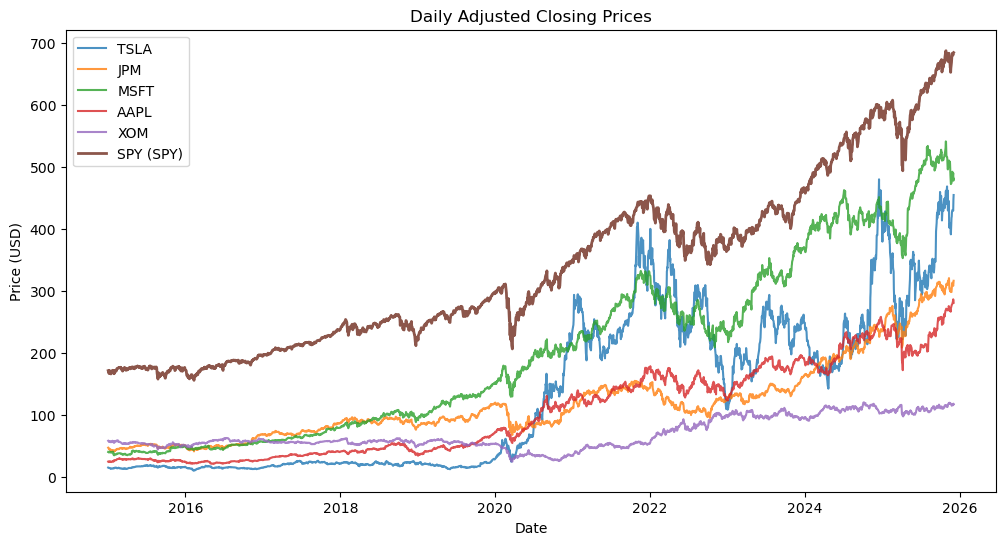

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
for t in tickers:
    ax.plot(prices.index, prices[t], label=t, alpha=0.8)

ax.plot(prices.index, prices[benchmark], label=benchmark + " (SPY)", linewidth=2)
ax.set_title("Daily Adjusted Closing Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
plt.show()

In [9]:
# daily returns
returns = prices.pct_change().dropna()
print(f"Returns shape: {returns.shape}")

print("="*50)

print("Summary statistics for daily returns:")
display(returns.describe().T)

Returns shape: (2747, 6)
Summary statistics for daily returns:


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,2747.0,0.001058,0.018223,-0.128647,-0.007315,0.000988,0.010067,0.153288
JPM,2747.0,0.000842,0.017106,-0.149649,-0.007031,0.000695,0.008930,0.180125
MSFT,2747.0,0.001051,0.016975,-0.147390,-0.006727,0.000955,0.009439,0.142169
TSLA,2747.0,0.001913,0.036449,-0.210628,-0.016543,0.001261,0.019591,0.226900
XOM,2747.0,0.000406,0.017302,-0.122248,-0.008200,0.000275,0.008992,0.126868
SPY,2747.0,0.000568,0.011235,-0.109424,-0.003706,0.000652,0.005928,0.105019


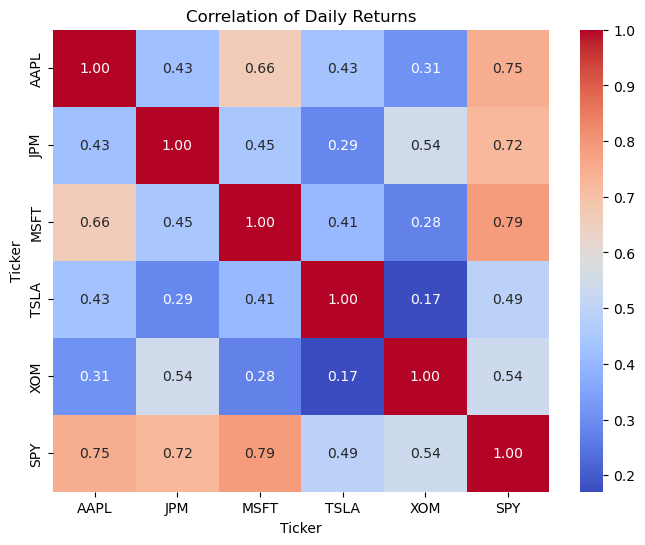

In [10]:
# correlation of returns
corr = returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Daily Returns")
plt.show()

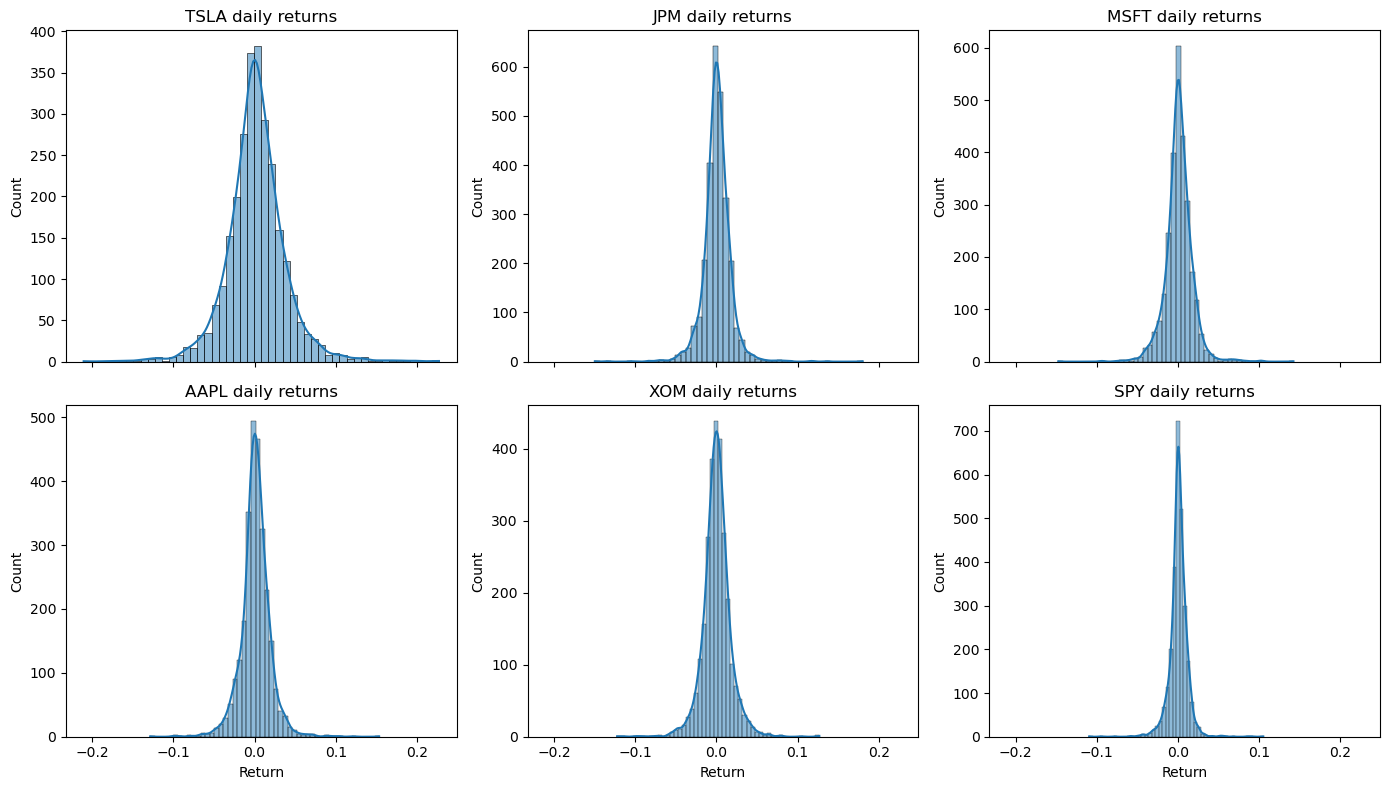

In [11]:
# hostogram of returns
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)
axes = axes.flatten()
all_tickers = tickers + [benchmark]

for i, t in enumerate(all_tickers):
    sns.histplot(returns[t], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{t} daily returns")
    axes[i].set_xlabel("Return")

for j in range(len(all_tickers), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Feature Engineering & Targets

In [12]:
df = prices.stack().reset_index()
df.columns = ["date", "ticker", "price"]
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

df["daily_return"] = df.groupby("ticker")["price"].pct_change()

# adding spy return
spy = df[df["ticker"] == benchmark][["date", "daily_return"]].rename(
    columns={"daily_return": "spy_return"}
)

stocks = df[df["ticker"].isin(tickers)].copy()
stocks = stocks.merge(spy, on="date", how="left")
stocks

,date,ticker,price,daily_return,spy_return
0,2015-01-02,AAPL,24.237551,NaN,NaN
1,2015-01-05,AAPL,23.554739,-0.028172,-0.018059
2,2015-01-06,AAPL,23.556959,0.000094,-0.009419
3,2015-01-07,AAPL,23.887278,0.014022,0.012461
4,2015-01-08,AAPL,24.805079,0.038422,0.017745
...,...,...,...,...,...
13735,2025-11-28,XOM,115.919998,0.010020,0.005458
13736,2025-12-01,XOM,116.629997,0.006125,-0.004565
13737,2025-12-02,XOM,115.379997,-0.010718,0.001852
13738,2025-12-03,XOM,117.800003,0.020974,0.003463


In [13]:
# Adding features:

# rolling 5 day mean and volatily of the returns for each ticker

stocks["mean_5d"] = (
    stocks.groupby("ticker")["daily_return"]
          .rolling(window=5, min_periods=5)
          .mean()
          .reset_index(level=0, drop=True)
)

stocks["vol_5d"] = (
    stocks.groupby("ticker")["daily_return"]
          .rolling(window=5, min_periods=5)
          .std()
          .reset_index(level=0, drop=True)
)
stocks

,date,ticker,price,daily_return,spy_return,mean_5d,vol_5d
0,2015-01-02,AAPL,24.237551,NaN,NaN,NaN,NaN
1,2015-01-05,AAPL,23.554739,-0.028172,-0.018059,NaN,NaN
2,2015-01-06,AAPL,23.556959,0.000094,-0.009419,NaN,NaN
3,2015-01-07,AAPL,23.887278,0.014022,0.012461,NaN,NaN
4,2015-01-08,AAPL,24.805079,0.038422,0.017745,NaN,NaN
...,...,...,...,...,...,...,...
13735,2025-11-28,XOM,115.919998,0.010020,0.005458,-0.001853,0.009179
13736,2025-12-01,XOM,116.629997,0.006125,-0.004565,-0.000731,0.009859
13737,2025-12-02,XOM,115.379997,-0.010718,0.001852,-0.000978,0.010145
13738,2025-12-03,XOM,117.800003,0.020974,0.003463,0.005734,0.011548


In [14]:
# adding forward 5-day return and classification label
stocks["price_5d_fwd"] = stocks.groupby("ticker")["price"].shift(-5)
stocks["ret_5d_fwd"] = stocks["price_5d_fwd"] / stocks["price"] - 1
stocks["up_5d"] = (stocks["ret_5d_fwd"] > 0).astype(int)

display(stocks.head())

,date,ticker,price,daily_return,spy_return,mean_5d,vol_5d,price_5d_fwd,ret_5d_fwd,up_5d
0,2015-01-02,AAPL,24.237551,NaN,NaN,NaN,NaN,24.831678,0.024513,1
1,2015-01-05,AAPL,23.554739,-0.028172,-0.018059,NaN,NaN,24.219816,0.028235,1
2,2015-01-06,AAPL,23.556959,0.000094,-0.009419,NaN,NaN,24.434855,0.037267,1
3,2015-01-07,AAPL,23.887278,0.014022,0.012461,NaN,NaN,24.341747,0.019026,1
4,2015-01-08,AAPL,24.805079,0.038422,0.017745,NaN,NaN,23.681105,-0.045312,0


In [15]:
# creating final modeling dataset
feature_cols = ["daily_return", "mean_5d", "vol_5d", "spy_return"]
target_reg = "ret_5d_fwd"
target_clf = "up_5d"

model_df = stocks.dropna(subset=feature_cols + [target_reg, target_clf]).copy()
model_df = model_df.sort_values("date").reset_index(drop=True)

model_df.head()


,date,ticker,price,daily_return,spy_return,mean_5d,vol_5d,price_5d_fwd,ret_5d_fwd,up_5d
0,2015-01-09,AAPL,24.831678,0.001072,-0.008013,0.005088,0.024178,23.497101,-0.053745,0
1,2015-01-09,MSFT,40.224983,-0.008405,-0.008013,0.001969,0.018562,39.415211,-0.020131,0
2,2015-01-09,TSLA,13.777333,-0.018802,-0.008013,-0.011661,0.019223,12.871333,-0.065760,0
3,2015-01-09,XOM,57.461441,-0.001410,-0.008013,-0.001462,0.016941,56.850033,-0.010640,0
4,2015-01-09,JPM,44.365818,-0.017387,-0.008013,-0.010098,0.021968,41.816307,-0.057466,0


###  Unsupervised Learning - K-Means Clustering


In [16]:
df.columns.tolist()

['date', 'ticker', 'price', 'daily_return']

In [17]:

# ------------------------------
# 1. Select numeric columns
# ------------------------------
X = df[['price', 'daily_return']].dropna()

# ------------------------------
# 2. Standardize data
# ------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# 3. Run K-Means
# ------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to df
df.loc[X.index, 'cluster'] = clusters.astype(int)

print(df['cluster'].value_counts())

cluster
0.0    7968
2.0    4576
1.0    3938
Name: count, dtype: int64


c:\Users\graso\anaconda3\envs\dsml\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


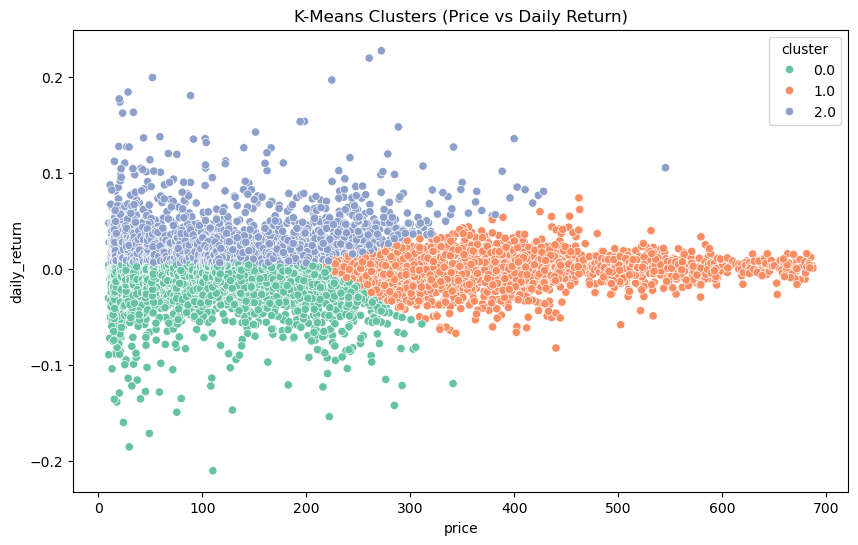

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='price',
    y='daily_return',
    hue='cluster',
    palette='Set2'
)
plt.title("K-Means Clusters (Price vs Daily Return)")
plt.show()


### Supervised Learning - Train/Test Split

In [19]:
X = model_df[feature_cols].values
y_clf = model_df[target_clf].values
y_reg = model_df[target_reg].values

tscv = TimeSeriesSplit(n_splits=5)

# store results for the final (most recent) fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_clf, y_test_clf = y_clf[train_idx], y_clf[test_idx]
    y_train_reg, y_test_reg = y_reg[train_idx], y_reg[test_idx]

# scale using ONLY training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])
print(f"Used fold: {fold+1} of {tscv.n_splits}")

Train size: 11409
Test size : 2281
Used fold: 5 of 5


### Classification Model: Predict Up/Down in 5 Days

In [20]:
# Predict Up/Down in 5 Days


# baseline: majority class from TRAINING data
majority_class = int(pd.Series(y_train_clf).mode()[0])
y_pred_baseline = np.full_like(y_test_clf, fill_value=majority_class)

baseline_acc = accuracy_score(y_test_clf, y_pred_baseline)
print(f"Baseline majority-class accuracy (TimeSeriesSplit): {baseline_acc:.3f}")

# using the logistic regression model from sklearn
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train_clf)

y_pred_clf = clf.predict(X_test_scaled)

clf_acc = accuracy_score(y_test_clf, y_pred_clf)
print(f"Logistic Regression accuracy (TimeSeriesSplit test fold): {clf_acc:.3f}")

print("\nClassification report:")
print(classification_report(y_test_clf, y_pred_clf, digits=3))

print("\nConfusion matrix:")
print(confusion_matrix(y_test_clf, y_pred_clf))

# showing feature importance
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": clf.coef_[0]
}).sort_values("coef", key=lambda s: s.abs(), ascending=False)

print("\nLogistic Regression coefficients:")
display(coef_df)


Baseline majority-class accuracy (TimeSeriesSplit): 0.569
Logistic Regression accuracy (TimeSeriesSplit test fold): 0.571

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.004     0.008       982
           1      0.570     1.000     0.727      1299

    accuracy                          0.571      2281
   macro avg      0.785     0.502     0.367      2281
weighted avg      0.755     0.571     0.417      2281


Confusion matrix:
[[   4  978]
 [   0 1299]]

Logistic Regression coefficients:


,feature,coef
1,mean_5d,0.037701
3,spy_return,-0.020379
0,daily_return,-0.011791
2,vol_5d,-0.006706


### Regression Model: Predict 5-Day Forward Return

In [21]:
# predict 5-Day Forward Return


# baseline: predict mean TRAINING 5-day return
baseline_mean = y_train_reg.mean()
y_pred_baseline = np.full_like(y_test_reg, baseline_mean)

baseline_mae = mean_absolute_error(y_test_reg, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_baseline))

print(f"Baseline MAE (TimeSeriesSplit):  {baseline_mae:.6f}")
print(f"Baseline RMSE (TimeSeriesSplit): {baseline_rmse:.6f}")

# linear regression from sklearn
reg = LinearRegression()
reg.fit(X_train_scaled, y_train_reg)

y_pred_reg = reg.predict(X_test_scaled)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("\nLinear Regression performance (TimeSeriesSplit test fold):")
print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R^2 : {r2:.4f}")

# coefficients for interpretability
reg_coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": reg.coef_
}).sort_values("coef", key=lambda s: s.abs(), ascending=False)

display(reg_coef_df)


Baseline MAE (TimeSeriesSplit):  0.034286
Baseline RMSE (TimeSeriesSplit): 0.051279

Linear Regression performance (TimeSeriesSplit test fold):
MAE : 0.034441
RMSE: 0.051437
R^2 : -0.0067


,feature,coef
2,vol_5d,0.002025
1,mean_5d,0.001154
3,spy_return,-0.000853
0,daily_return,-0.000442


### Save Models for Deployment


In [22]:
import joblib
import os

# create model directory if it doesn't exist
os.makedirs("model", exist_ok=True)

# save the scaler used for supervised learning
joblib.dump(scaler, "model/scaler.joblib")
print("Saved: model/scaler.joblib")

# save the classifier
joblib.dump(clf, "model/classifier.joblib")
print("Saved: model/classifier.joblib")

# save the regressor
joblib.dump(reg, "model/regressor.joblib")
print("Saved: model/regressor.joblib")

# save feature column names for API validation
import json
with open("model/feature_cols.json", "w") as f:
    json.dump(feature_cols, f)
print("Saved: model/feature_cols.json")

print("\nAll models saved successfully!")


Saved: model/scaler.joblib
Saved: model/classifier.joblib
Saved: model/regressor.joblib
Saved: model/feature_cols.json

All models saved successfully!
